In [56]:
import torch
import random
import numpy as np

seedInt = 55667
torch.manual_seed(seedInt)
random.seed(seedInt)
np.random.seed(seedInt)
torch.use_deterministic_algorithms(False)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import re
import warnings

warnings.filterwarnings("ignore")

import pandas as pd

from gensim.models import KeyedVectors

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import json

ReviewList = []
data = open('/content/drive/MyDrive/Colab Notebooks/reviews.json','r').readlines()
result = []
for ele in data:
    result.append(json.loads(ele))
    
df = pd.DataFrame.from_dict(result, orient='columns')
df.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4.0,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5.0,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5.0,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4.0,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5.0,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"
5,APX47D16JOP7H,120401325X,RLH,"[1, 2]",These make using the home button easy. My daug...,3.0,Cute,1381536000,"10 12, 2013"
6,A1JVVYYO7G56DS,120401325X,Tyler Evans,"[0, 0]",Came just as described.. It doesn't come unstu...,5.0,best thing ever..,1377129600,"08 22, 2013"
7,A6FGO4TBZ3QFZ,3998899561,Abdullah Albyati,"[1, 2]",it worked for the first week then it only char...,1.0,not a good Idea,1384992000,"11 21, 2013"
8,A2JWEDW5FSVB0F,3998899561,Adam,"[2, 3]","Good case, solid build. Protects phone all aro...",5.0,Solid Case,1380067200,"09 25, 2013"
9,A8AJS1DW7L3JJ,3998899561,Agata Majchrzak,"[1, 1]",This is a fantastic case. Very stylish and pro...,5.0,Perfect Case,1396483200,"04 3, 2014"


In [5]:
review_df = df[['reviewText','overall']]
review_df['overall'] = review_df['overall']-1
review_df.head()

,reviewText,overall
0,They look good and stick good! I just don't li...,3.0
1,These stickers work like the review says they ...,4.0
2,These are awesome and make my phone look so st...,4.0
3,Item arrived in great time and was in perfect ...,3.0
4,"awesome! stays on, and looks great. can be use...",4.0


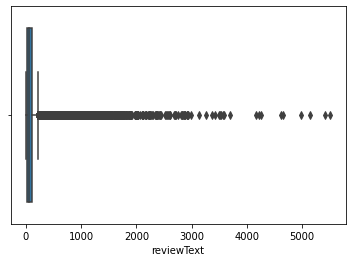

In [7]:
re_wordMatcher = re.compile(r'[a-z0-9]+') #Declare regex to extract words
numWords = review_df["reviewText"].map(lambda x: len(re_wordMatcher.findall(x.lower())))
g = sns.boxplot(numWords)

In [8]:
reviewLen90 = np.quantile(numWords, 0.90)
print("90th quantile of review length:", reviewLen90)

90th quantile of review length: 214.0


In [10]:
maxlen = 214

skf = StratifiedKFold(n_splits=5)
for trn_idx, tst_idx in skf.split(review_df['reviewText'],review_df['overall']):
    break

train_df, test_df = review_df.iloc[trn_idx], review_df.iloc[tst_idx]

print("Shape of train and test dataframes:", train_df.shape, test_df.shape)

Shape of train and test dataframes: (155551, 2) (38888, 2)


In [11]:
!pip install wget
import wget
word2VecFile = os.path.join(os.curdir, 'wiki.multi.en.vec')

if os.path.exists(word2VecFile):
    print('Word2Vec file has been found and is being loaded...')
else:    
    print('Word2Vec file does not exist and needs to be downloaded')
    url = 'https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec'
    wget.download(url)
    print('Downloading from', url)
en_model = KeyedVectors.load_word2vec_format('wiki.multi.en.vec')

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=97b1880c597e1c1b58046d1fee32c7e98be8e005eba4ef68dfa68d6b2971d10d
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Word2Vec file does not exist and needs to be downloaded


In [12]:
embeddingDim = 300

vocab = list(en_model.vocab.keys())
print("Vocab size in pretrained model:", len(vocab))

# check if the word 'and' is present in the pretrained model
assert "and" in en_model

# check the dimension of the word vectors
assert embeddingDim == len(en_model["and"])

# initialize a numpy matrix which will store the word vectors
# first row is for the padding token
pretrained_weights = np.zeros((1+len(vocab), embeddingDim))

# tqdm just adds a progress bar
for i, token in enumerate(vocab):
    pretrained_weights[i, :] = en_model[token]

# map tokens in the vocab to ids
vocab = dict(zip(vocab, range(1, len(vocab)+1)))

Vocab size in pretrained model: 200000


In [13]:
def reviewText2Features(reviewText):
    X = []
    
    reviewWords = re_wordMatcher.findall(reviewText.lower())
    
    for i, word in enumerate(reviewWords):
        if word not in en_model:
            continue
        if i >= maxlen:
            break
        # X.append(en_model[word])
        X.append(vocab[word])

    if len(X) < maxlen:
        # zero_padding = [[0.]*embeddingDim]*(maxlen - len(X))
        zero_padding = [0.]*(maxlen - len(X))
        X = zero_padding + X
    
    return X # np.array(X)
        
def row2Features(row):   
    
    X = reviewText2Features(row["reviewText"])
    y = row["overall"]
        
    return X, y

In [14]:
sampleRow = review_df.iloc[0]
reviewWords = re_wordMatcher.findall(sampleRow["reviewText"].lower())
print("Review:", sampleRow["reviewText"])
print("Rating:", sampleRow["overall"])
#print("Sentiment:", sampleRow["Sentiment"])
print("Review words:", reviewWords)

Review: They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again
Rating: 3.0
Review words: ['they', 'look', 'good', 'and', 'stick', 'good', 'i', 'just', 'don', 't', 'like', 'the', 'rounded', 'shape', 'because', 'i', 'was', 'always', 'bumping', 'it', 'and', 'siri', 'kept', 'popping', 'up', 'and', 'it', 'was', 'irritating', 'i', 'just', 'won', 't', 'buy', 'a', 'product', 'like', 'this', 'again']


In [15]:
X, y = row2Features(sampleRow)
print("Dimension of X:", len(X))
print("Label y:", y)

Dimension of X: 214
Label y: 3.0


In [16]:
def shuffleArray(X, y):
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    X = X[idx, :]
    y = y[idx]
    return X, y

def generateModelReadyData(data, batchSize = 128, shuffle=False):
    
    while(True):
        X = []
        y = []
        for _, row in data.iterrows():
            """Generate features and label for this row"""
            X_, y_ = row2Features(row)

            """Keep accumulating the row-wise features"""
            X.append(X_)
            y.append(y_)   

            """If number of rows processed is greater than batchSize yield the batch and trim down X & y
            Note: This way we avoid running into memory issues by not bloating X and y bigger and bigger
            """
            if len(X) > batchSize:
                temp_X, temp_y = np.array(X[:batchSize]), np.array(y[:batchSize])
                if shuffle:
                    temp_X, temp_y = shuffleArray(temp_X, temp_y)
                
                X, y = X[batchSize:], y[batchSize:]                    
                yield temp_X, temp_y

        """Yield the remaining few rows when number of rows in data isn't a mutiple of batchSize"""
        if len(X) > 0:
            temp_X, temp_y = np.array(X), np.array(y)
            if shuffle:
                temp_X, temp_y = shuffleArray(temp_X, temp_y)
            
            yield temp_X, temp_y

In [17]:
numBatches = 0
for i, (X, y) in enumerate(generateModelReadyData(review_df, batchSize=128, shuffle=True)):
    if numBatches >= 3:
        break
    
    else:
        print("Batch:", i)
        assert X.shape == (128, maxlen)
        assert y.shape == (128,)
        print("Shape of X & y matches expected values")
    numBatches += 1

Batch: 0
Shape of X & y matches expected values
Batch: 1
Shape of X & y matches expected values
Batch: 2
Shape of X & y matches expected values


In [18]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    print("cuda available")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

cuda available


In [57]:
class SentimentNet(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, pretrained_weights):
        super(SentimentNet, self).__init__()
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
        self.sentInputDropout = nn.Dropout(0.1)
        self.biLSTM1 = nn.LSTM(embedding_dim, hidden_dim[0], bidirectional=True, batch_first=True)
        self.biLSTMDropOut = nn.Dropout(0.1)
        self.dense1 = nn.Linear(2*hidden_dim[0], 50)
        self.relu1 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.outputLayer = nn.Linear(50, 5)
        
    def forward(self, x):
        
        batch_len = x.shape[0]
        out = self.embedding(x)
        out = self.sentInputDropout(out)
        out, hidden = self.biLSTM1(out)
        out = self.biLSTMDropOut(out)
        out = self.dense1(out)
        out = self.relu1(out)
        out = self.dropout2(out)
        out = self.outputLayer(out)
        #out = out.view(batch_len, -1)
        out = out[:,-1]
        return out    

In [58]:
model = SentimentNet(embeddingDim, [100], 1+len(vocab), pretrained_weights)
model.to(device)

SentimentNet(
  (embedding): Embedding(200001, 300)
  (sentInputDropout): Dropout(p=0.1, inplace=False)
  (biLSTM1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (biLSTMDropOut): Dropout(p=0.1, inplace=False)
  (dense1): Linear(in_features=200, out_features=50, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (outputLayer): Linear(in_features=50, out_features=5, bias=True)
)

In [59]:
lr=0.05
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=lr)

In [60]:
epochs = 1
counter = 0
print_every = 500
clip = 5
valid_loss_min = np.Inf

model = model.float()
model.train()
for i in range(epochs):
    print("Running a pass over the training data...")
    for j, (inputs, labels) in enumerate(generateModelReadyData(train_df, batchSize=128, shuffle=True)):
        if j >= np.ceil(train_df.shape[0]/128):
            break
        
    #for inputs, labels in train_loader:
        counter += 1
        inputs, labels = torch.from_numpy(inputs), torch.from_numpy(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs.long())
        loss = criterion(output, labels.type(torch.LongTensor).to(device))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()        
        if (j+1) % 100 == 0:
            print("Batches completed:", j+1)
    
    print("Batches completed:", j+1)
    val_losses = []
    model.eval()
    print("Running a pass over the test data...")
    for k, (inp, lab) in enumerate(generateModelReadyData(test_df, batchSize=128, shuffle=False)):
        if k >= np.ceil(test_df.shape[0]/128):
            break
    #for inp, lab in val_loader:
        inp, lab = torch.from_numpy(inp), torch.from_numpy(lab)
        inp, lab = inp.to(device), lab.to(device)
        out = model(inp.long())
        val_loss = criterion(out.squeeze(), lab.type(torch.LongTensor).to(device))
        val_losses.append(val_loss.item())
        if (k+1) % 100 == 0:
            print("Batches completed:", k+1)
    
    print("Batches completed:", k+1)

    model.train()
    print("Epoch: {}/{}...".format(i+1, epochs),
          "Step: {}...".format(counter),
          "Loss: {:.6f}...".format(loss.item()),
          "Val Loss: {:.6f}".format(np.mean(val_losses)))
    if np.mean(val_losses) <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
        valid_loss_min = np.mean(val_losses)

Epoch: 1
Running a pass over the training data...
Batches completed: 100
Batches completed: 200
Batches completed: 300
Batches completed: 400
Batches completed: 500
Batches completed: 600
Batches completed: 700
Batches completed: 800
Batches completed: 900
Batches completed: 1000
Batches completed: 1100
Batches completed: 1200
Batches completed: 1217
Running a pass over the test data...
Batches completed: 100
Batches completed: 200
Batches completed: 300
Batches completed: 305
Epoch: 1/1... Step: 1216... Loss: 0.368505... Val Loss: 1.193968
Validation loss decreased (inf --> 1.193968).  Saving model ...


In [48]:
"""
At this point we can load a pretrained model which was trained for 5 epochs and make predictions using it.
Uncomment and run the below line to load the pretrained model
"""
model.load_state_dict(torch.load('./state_dict.pt'))
model.to(device)

SentimentNet(
  (embedding): Embedding(200001, 300)
  (sentInputDropout): Dropout(p=0.1, inplace=False)
  (biLSTM1): LSTM(300, 100, batch_first=True, bidirectional=True)
  (biLSTMDropOut): Dropout(p=0.1, inplace=False)
  (dense1): Linear(in_features=200, out_features=50, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (outputLayer): Linear(in_features=50, out_features=5, bias=True)
)

In [61]:
test_losses = []
num_correct = 0
pred_proba = []
actual = []

model.eval()
for j, (X_test, y_test) in enumerate(generateModelReadyData(test_df, batchSize=128)):
    if j >= np.ceil(test_df.shape[0]/128):
        break
    
    inputs_test, labels_test = torch.from_numpy(X_test), torch.from_numpy(y_test)
    inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
    output_test = model(inputs_test.long())
    test_loss = criterion(output_test.squeeze(), labels_test.type(torch.LongTensor).to(device))
    test_losses.append(test_loss.item())
    _, predicted = torch.max(output_test, 1) 
    correct_tensor = predicted.eq(labels_test.long())
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    pred_proba.extend(output_test.cpu().squeeze().detach().numpy())
    actual.extend(y_test)
    
    if (j+1) % 100 == 0:
        print("Batches completed:", j+1)

print("Batches completed:", j+1)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_df)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Batches completed: 100
Batches completed: 200
Batches completed: 300
Batches completed: 305
Test loss: 1.194
Test accuracy: 55.886%
